# Generate Urban Inputs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import osmnx as ox
import rasterio
import multiprocessing as mp
import json

from pathlib import Path
from rasterio.plot import show

%matplotlib inline

In [2]:
data_path = Path(".").resolve().parent / "vina_del_mar"
epsg = "epsg:4326"
urban_mask = gpd.read_file(data_path / "urban" / "urban_mask.shp").to_crs(epsg)
shelters_raw = gpd.read_file(data_path / "shelters" / "shelters_raw.shp").to_crs(epsg)
elevation_filepath = data_path / "urban" / "urban_elevation.asc"
elevation = rasterio.open(elevation_filepath)

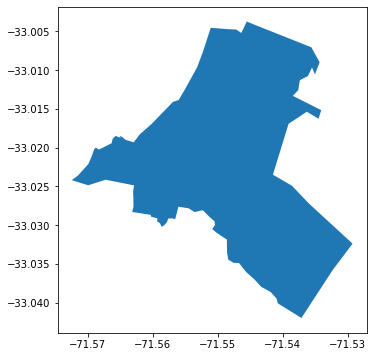

In [3]:
fig, ax = plt.subplots(figsize=(6, 6))
urban_mask.to_crs(epsg).plot(ax=ax)
fig.show()

## Urban Network

In [4]:
G = ox.graph_from_polygon(
    urban_mask.unary_union,
    network_type="walk",
    simplify=False
)
G = ox.project_graph(G, to_crs=elevation.crs)
ox.add_node_elevations_raster(
    G,
    elevation_filepath,
    band=1
)
ox.elevation.add_edge_grades(G, add_absolute=False, precision=3)
G = ox.project_graph(G, to_crs=epsg)
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

## Evacuation Routes

In [5]:
def euclidean_dist(a, b, G=G):
    x1 = G.nodes[a]["x"]
    y1 = G.nodes[a]["y"]
    x2 = G.nodes[b]["x"]
    y2 =  G.nodes[b]["y"]
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


def get_evacuation_route(G, origin, targets, weight="weight", heuristic=None):
    paths = {target: nx.astar_path(G, origin, target, heuristic, weight) for target in targets}
    lengths = {target: sum(ox.utils_graph.get_route_edge_attributes(G, path, weight)) for target, path in paths.items()}
    best_target = min(lengths, key=lengths.get)
    return (origin, paths[best_target][1:])


def get_evacuation_routes_parallel(args, cpus=None):
    pool = mp.Pool(cpus)
    sma = pool.starmap_async(get_evacuation_route, args)
    evacuation_routes = sma.get()
    pool.close()
    pool.join()
    return {origin: route for origin, route in evacuation_routes}

In [6]:
horizontal_shelter_nodes_id = ox.distance.nearest_nodes(
    G,
    X=shelters_raw.loc[lambda x: x["evac_type"] == "horizontal", "x"].values,
    Y=shelters_raw.loc[lambda x: x["evac_type"] == "horizontal", "y"].values
)
horizontal_args = ((G, origin, horizontal_shelter_nodes_id, "length", None) for origin in G.nodes)
horizontal_evacuation_routes = get_evacuation_routes_parallel(horizontal_args)

In [7]:
vertical_shelter_nodes_id = ox.distance.nearest_nodes(
    G,
    X=shelters_raw.loc[lambda x: x["evac_type"] == "vertical", "x"].values,
    Y=shelters_raw.loc[lambda x: x["evac_type"] == "vertical", "y"].values
)
vertical_args = ((G, origin, vertical_shelter_nodes_id, "length", None) for origin in G.nodes)
vertical_evacuation_routes = get_evacuation_routes_parallel(vertical_args)

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [8]:
shelter_nodes_id = ox.distance.nearest_nodes(
    G,
    X=shelters_raw.loc[:, "x"].values,
    Y=shelters_raw.loc[:, "y"].values
)
alternative_args = (
    (
        G,
        origin,
        [shelter for shelter in shelter_nodes_id if origin != shelter],
        "length",
        None
    ) for origin in shelter_nodes_id
)
alternative_evacuation_routes = get_evacuation_routes_parallel(alternative_args)

### Write outputs

In [9]:
urban_nodes = (
    nodes.reset_index()
    .rename(columns={"osmid": "id"})
    .loc[: ,["id", "x", "y", "geometry"]]
)
urban_nodes.head()

,id,x,y,geometry
0,252673360,-71.551429,-33.022482,POINT (-71.55143 -33.02248)
1,253107884,-71.551447,-33.022566,POINT (-71.55145 -33.02257)
2,254026566,-71.550188,-33.022666,POINT (-71.55019 -33.02267)
3,302967549,-71.551537,-33.022467,POINT (-71.55154 -33.02247)
4,254026932,-71.551231,-33.021511,POINT (-71.55123 -33.02151)


In [10]:
urban_network = (
    edges.reset_index()
    .rename(
        columns={
            "osmid": "id",
            "u": "from_id",
            "v": "to_id",
            "grade": "slope",
        }
    )
    .assign(
        weight=lambda x: x["length"],
        sidewalks=2,
        sd_width=2
    )
    .loc[
        :,
        [
            "id",
            "from_id",
            "to_id",
            "length",
            "slope",
            "weight",
            "sidewalks",
            "sd_width",
            "geometry"

        ]
    ]
)
urban_network.head()

,id,from_id,to_id,length,slope,weight,sidewalks,sd_width,geometry
0,242043349,252673360,253107884,9.501,-0.003,9.501,2,2,"LINESTRING (-71.55143 -33.02248, -71.55145 -33..."
1,288368027,252673360,254026566,117.509,0.000,117.509,2,2,"LINESTRING (-71.55143 -33.02248, -71.55019 -33..."
2,452081060,252673360,302967549,10.221,-0.000,10.221,2,2,"LINESTRING (-71.55143 -33.02248, -71.55154 -33..."
3,551701500,252673360,254026932,109.476,0.003,109.476,2,2,"LINESTRING (-71.55143 -33.02248, -71.55123 -33..."
4,23927111,253107884,252674355,5.721,-0.002,5.721,2,2,"LINESTRING (-71.55145 -33.02257, -71.55146 -33..."


In [11]:
shelters_node = (
    pd.DataFrame(
        {
            "id": shelter_nodes_id,
            "evac_type": shelters_raw.loc[:, "evac_type"].values,
            "capacity": shelters_raw.loc[:, "capacity"].values
        }
    )
    .merge(urban_nodes, how="inner")
    .loc[
        :,
        ["id", "x", "y", "evac_type", "geometry"]
    ]
    .pipe(lambda x: gpd.GeoDataFrame(x))
)
shelters_node.head()

,id,x,y,evac_type,geometry
0,2720301204,-71.550425,-33.004617,horizontal,POINT (-71.55042 -33.00462)
1,6131669502,-71.538649,-33.041187,horizontal,POINT (-71.53865 -33.04119)
2,6131669502,-71.538649,-33.041187,horizontal,POINT (-71.53865 -33.04119)
3,6131669502,-71.538649,-33.041187,horizontal,POINT (-71.53865 -33.04119)
4,6131669502,-71.538649,-33.041187,horizontal,POINT (-71.53865 -33.04119)


In [12]:
urban_nodes.to_file(data_path / "urban"/ "urban_nodes.shp")
urban_network.to_file(data_path / "urban"/ "urban_network.shp")
shelters_node.to_file(data_path / "shelters"/ "shelters_node.shp")

In [13]:
with (data_path / "evacuation_routes" / "shortest" / "horizontal_evacuation_routes.json").open("w") as f:
    json.dump(horizontal_evacuation_routes, f)

with (data_path / "evacuation_routes" / "shortest" / "vertical_evacuation_routes.json").open("w") as f:
    json.dump(vertical_evacuation_routes, f)

with (data_path / "evacuation_routes" / "shortest" / "alternative_evacuation_routes.json").open("w") as f:
    json.dump(alternative_evacuation_routes, f)
